In [112]:
import pandas as pd
import numpy as np
import geopandas as gpd
from pandas import IndexSlice as idx

from shapely import geometry

from scipy import interpolate
from spatial_interpolation.visualization import map_viz

import osmnx as ox

import glob

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [308]:
buoy_locations_info_df = pd.read_csv("references/buoy_locations.csv")
parquet_files = glob.glob("data/04_feature/buoy_stdmet_data/*.parquet")
df = pd.concat(
    [pd.read_parquet(f) for f in parquet_files],
    axis="index",
)
gdf = gpd.GeoDataFrame(buoy_locations_info_df)
gdf["geometry"] = gpd.GeoSeries.from_xy(
    gdf.longitude,gdf.latitude
).drop(columns=["latitude","longitude"])
gdf

,buoy_id,buoy_name,latitude,longitude,year,geometry
0,41003,41003 NORTH FLORIDA,30.300,-80.400,1979,POINT (-80.40000 30.30000)
1,41003,41003 NORTH FLORIDA,30.300,-80.400,1980,POINT (-80.40000 30.30000)
2,41003,41003 NORTH FLORIDA,30.300,-80.400,1981,POINT (-80.40000 30.30000)
3,41003,41003 NORTH FLORIDA,30.300,-80.400,1982,POINT (-80.40000 30.30000)
4,41006,"41006 E DAYTONA, FL",29.300,-77.300,1982,POINT (-77.30000 29.30000)
...,...,...,...,...,...,...
1850,41040,41040 West Atlantic,14.554,-53.045,2019,POINT (-53.04500 14.55400)
1851,41040,41040 West Atlantic,14.554,-53.045,2020,POINT (-53.04500 14.55400)
1852,41040,41040 West Atlantic,14.554,-53.045,2021,POINT (-53.04500 14.55400)
1853,41040,41040 West Atlantic,14.542,-53.341,2021,POINT (-53.34100 14.54200)


In [48]:
world_countries = gpd.read_file("references/world_borders/TM_WORLD_BORDERS-0.3.shp")
df_countries = world_countries[world_countries.overlaps(geometry.box(*gdf.total_bounds.tolist()))]
df_countries

,FIPS,ISO2,ISO3,UN,NAME,AREA,POP2005,REGION,SUBREGION,LON,LAT,geometry
54,ES,SV,SLV,222,El Salvador,2072,6668356,19,13,-88.866,13.736,"MULTIPOLYGON (((-87.68640 13.16833, -87.70361 ..."
74,GT,GT,GTM,320,Guatemala,10843,12709564,19,13,-90.398,15.256,"POLYGON ((-90.62762 13.93056, -90.67334 13.929..."
78,HO,HN,HND,340,Honduras,11189,683411,19,13,-86.863,14.819,"MULTIPOLYGON (((-87.62251 13.24639, -87.62889 ..."
119,MX,MX,MEX,484,Mexico,190869,104266392,19,13,-102.535,23.951,"MULTIPOLYGON (((-114.74278 18.32278, -114.7897..."
158,NU,NI,NIC,558,Nicaragua,12140,5462539,19,13,-85.034,12.840,"MULTIPOLYGON (((-83.71251 11.86833, -83.71501 ..."
208,US,US,USA,840,United States,915896,299846449,19,21,-98.606,39.622,"MULTIPOLYGON (((-75.17029 19.93139, -75.22372 ..."
226,NT,AN,ANT,530,Netherlands Antilles,80,186392,19,29,-68.870,12.123,"MULTIPOLYGON (((-68.19528 12.22111, -68.19278 ..."


In [ ]:
# Buoys that overlap land and dont
land_buoys = gdf.geometry.apply(lambda x: any(df_countries.intersects(x,align=False)))
map_viz.add_geodf_to_map(
    gdf,
    radius=1,
    weight=5,
    map_args={"zoom_start":5},
    popup=lambda x: f"{x.buoy_name} ({x.name})",
    color=lambda x: "red" if land_buoys[x.name] else "blue",
)

In [309]:
buoys_gdf = gdf[~land_buoys].drop_duplicates(
    subset=["buoy_id","year"]
).set_index(["buoy_id","year"]).sort_index()
buoys_df = df.set_index(["buoy_id","time"]).sort_index()

In [107]:
# times with the most data points
df.set_index(
    ["buoy_id","time"]
)[["wave_height","wind_direction"]].groupby(
    "time"
).count().sort_values(
    by=["wave_height","wind_direction","time"],
    ascending=False
).head(10)

,wave_height,wind_direction
time,,
2011-07-02 19:00:00,34,34
2011-07-02 18:00:00,34,34
2011-07-02 17:00:00,34,34
2011-07-02 16:00:00,34,34
2011-07-02 13:00:00,34,34
2011-07-01 18:00:00,34,34
2011-07-01 16:00:00,34,34
2011-07-01 15:00:00,34,34
2011-07-01 14:00:00,34,34


## Perform and evaluate the interpolations

In [227]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [317]:
def plot_interpolation(x,y,x_test,y_test,interpolator,title=None,bbox=None,df_countries=None,num_points=100):
    """
    Plots the interpolation of the data as a heatmap and the data points
    """
    if bbox is not None:
        xmin, ymin, xmax, ymax = bbox
    else:
        xmin, xmax = min(x.min(),x_test.min()), max(x.max(),x_test.max())
        ymin, ymax = min(y.min(),y_test.min()), max(y.max(),y_test.max())

    X = np.linspace(xmin,xmax,num_points)
    Y = np.linspace(ymin,ymax,num_points)
    X,Y = np.meshgrid(X,Y)
    Z = interpolator(X,Y)
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    ax = df_countries.plot(ax=ax,zorder=1)
    ax.set_xlim(xmin,xmax); ax.set_ylim(ymin,ymax)
    print(Z.shape)
    CS = ax.contourf(X,Y,Z,cmap="rainbow",zorder=0)
    fig.colorbar(CS)
    # plot the training points
    ax.scatter(x,y,c="black",marker="o",s=5,zorder=10)
    # plot the test points
    ax.scatter(x_test,y_test,c="r",marker="x",s=50,zorder=10)
    if title is None:
        title = f"{interpolator.__class__.__name__} interpolation"
    # buoys_gdf.plot(ax=ax,color='black',zorder=2)
    ax.set(title=title,xlabel="longitude",ylabel="latitude");

In [310]:
y_col = "wave_height"
data = buoys_df.loc[idx[:,"2011-07-02 17:00":"2011-07-02 19:00"],:]\
        .dropna(how="any",axis=1)\
            .reset_index()\
                .drop_duplicates(subset=["buoy_id"])\
                    .set_index(["buoy_id"])\
                        .assign(year=lambda x: x.time.dt.year)\
                            .join(buoys_gdf[["geometry"]],on=["buoy_id","year"])\
                                .drop(columns=["time","year"])

In [340]:
X_train, X_test, Y_train, Y_test = train_test_split(
    data.drop(columns=y_col), data[y_col], 
    test_size=0.2, 
    # random_state=42
)

# get the coordinates and values of each split
x = X_train.geometry.apply(lambda x: x.x)
y = X_train.geometry.apply(lambda x: x.y)
z = Y_train

x_test = X_test.geometry.apply(lambda x: x.x)
y_test = X_test.geometry.apply(lambda x: x.y)
z_test = Y_test

(100, 100)


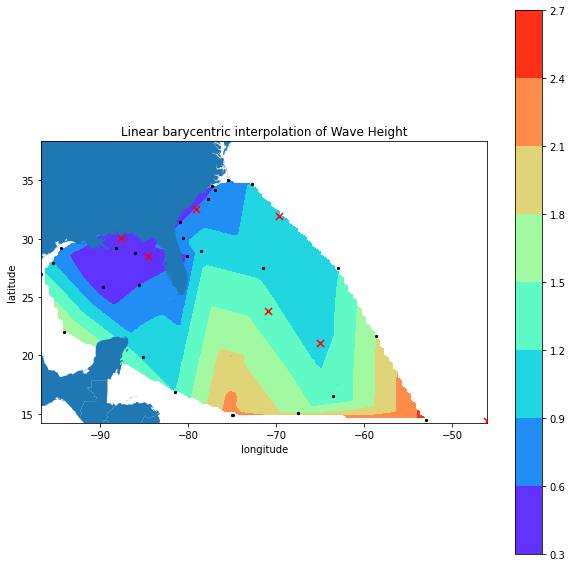

In [355]:
from scipy import interpolate
from spatial_interpolation.visualization import plot_interpolation
# build the interpolator
interpolator = interpolate.LinearNDInterpolator(
    list(zip(x,y)),z,fill_value=np.nan
)
# plot the interpolation
plot_interpolation(
    x,y,
    x_test,y_test,
    interpolator,
    bbox=buoys_gdf.total_bounds,
    df_countries=df_countries,
    title="Linear barycentric interpolation of Wave Height"
)

In [357]:
# perform the interpolation of the test points and calculate the metrics
z_interp = interpolator(x_test,y_test)
pred = z_interp[~np.isnan(z_interp)]
true = z_test[~np.isnan(z_interp)]
metrics_dict = {
    "mse":mean_squared_error(true,pred),
    "mae":mean_absolute_error(true,pred),
    "r2":r2_score(true,pred),
}
display(pd.DataFrame({"y_hat":z_interp,"y_true":z_test}).assign(
    mae=lambda x: np.abs(x["y_hat"]-x["y_true"]),
    mse=lambda x: (x["y_hat"]-x["y_true"])**2
))
display(pd.DataFrame(metrics_dict,index=[0]))

,,y_hat,y_true,mae,mse
buoy_id,year,,,,
41043,2011,1.189595,1.98,0.790405,0.624740
41041,2011,NaN,2.29,NaN,NaN
41004,2011,0.618057,0.69,0.071943,0.005176
41048,2011,1.019004,1.11,0.090996,0.008280
42012,2011,0.553065,0.44,0.113065,0.012784
42036,2011,0.491335,0.62,0.128665,0.016555
41046,2011,1.307849,1.59,0.282151,0.079609


,mse,mae,r2
0,0.124524,0.246204,0.594799


(100, 100)


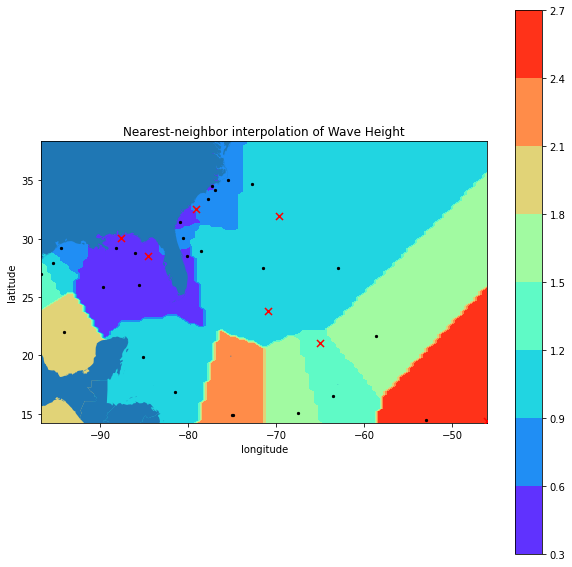

In [359]:
# build the interpolator
interpolator = interpolate.NearestNDInterpolator(
    list(zip(x,y)),z,tree_options=None
)
# plot the interpolation
plot_interpolation(
    x,y,
    x_test,y_test,
    interpolator,
    bbox=buoys_gdf.total_bounds,
    df_countries=df_countries,
    title="Nearest-neighbor interpolation of Wave Height"
)

In [360]:
# perform the interpolation of the test points and calculate the metrics
y_interp = interpolator(x_test,y_test)
metrics_dict = {
    "mse":mean_squared_error(z_test,y_interp),
    "mae":mean_absolute_error(z_test,y_interp),
    "r2":r2_score(z_test,y_interp),
}
display(pd.DataFrame({"y_hat":y_interp,"y_true":z_test}).assign(
    mae=lambda x: np.abs(x["y_hat"]-x["y_true"]),
    mse=lambda x: (x["y_hat"]-x["y_true"])**2
))
display(pd.DataFrame(metrics_dict,index=[0]))

,,y_hat,y_true,mae,mse
buoy_id,year,,,,
41043,2011,1.22,1.98,0.76,0.5776
41041,2011,2.51,2.29,0.22,0.0484
41004,2011,0.64,0.69,0.05,0.0025
41048,2011,0.93,1.11,0.18,0.0324
42012,2011,0.54,0.44,0.10,0.0100
42036,2011,0.45,0.62,0.17,0.0289
41046,2011,1.11,1.59,0.48,0.2304


,mse,mae,r2
0,0.132886,0.28,0.701493
